In [1]:
import sys
print sys.executable

paths = ['', '/Users/dyawitz/anaconda/bin', '/Users/dyawitz/anaconda/lib/python27.zip', '/Users/dyawitz/anaconda/lib/python2.7/plat-darwin', '/Users/dyawitz/anaconda/lib/python2.7/plat-mac', '/Users/dyawitz/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/dyawitz/anaconda/lib/python2.7/lib-tk', '/Users/dyawitz/anaconda/lib/python2.7/lib-old', '/Users/dyawitz/anaconda/lib/python2.7/lib-dynload', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/Sphinx-1.3.1-py2.7.egg', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/setuptools-18.5-py2.7.egg', '/Users/dyawitz/anaconda/lib/python2.7/site-packages', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/aeosa', '/Users/dyawitz/anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/dyawitz/.ipython']

for i in paths:
   sys.path.append(i)

/Users/dyawitz/anaconda/envs/py27/bin/python


Take the files for each region in the NYISO, concatenate them into one, and build a model on them. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

In [4]:
weather_dict = joblib.load('weather_dict.pkl')

In [8]:
weather_dict['N.Y.C.']

('kjfk', 'NYC', 'NYC')

In [46]:
region = 'N.Y.C.'
place = weather_dict[region][1].lower().replace(' ','')
full = pd.read_csv('full_{0}_features.csv'.format(place))

In [47]:
full.head()

timestamp    load          weathertime  temperaturef  dewpointf  \
0  2012-01-01 00:00:00  5061.5  2012-01-01 00:51:00            46         37   
1  2012-01-01 00:00:00  5061.5  2012-01-01 00:51:00            46         37   
2  2012-01-01 00:05:00  5030.0  2012-01-01 00:51:00            46         37   
3  2012-01-01 00:05:00  5030.0  2012-01-01 00:51:00            46         37   
4  2012-01-01 00:10:00  5011.5  2012-01-01 00:51:00            46         37   

   humidity  sealevelpressurein winddirection  windspeedmph  precipitationin  \
0        71               30.04           WNW          10.4                0   
1        71               30.04           WNW          10.4                0   
2        71               30.04           WNW          10.4                0   
3        71               30.04           WNW          10.4                0   
4        71               30.04           WNW          10.4                0   

   dow  doy  day  month  year  hour  minute   t_m24   t_m48  tdif  
0    6    1    1      1  2012     0       0  5061.5  5061.5     0  
1    6    1    1      1  2012     0       0  5061.5  5061.5     0  
2    6    1    1      1  2012     0       5  5030.0  5030.0     0  
3    6    1    1      1  2012     0       5  5030.0  5030.0     0  
4    6    1    1      1  2012     0      10  5011.5  5011.5     0

In [48]:
full.dropna(inplace=True)

In [49]:
%time full['timestamp'] = full['timestamp'].apply(lambda x: pd.to_datetime(x))

CPU times: user 55.8 s, sys: 965 ms, total: 56.8 s
Wall time: 57.3 s


In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split

In [66]:
features = [\
          'temperaturef',\
#           'dewpointf', \
#           'humidity', \
#           'sealevelpressurein', \
#          'windspeedmph', \
#           'precipitationin',\
            'year',\
          'dow',\
          'doy', \
#           'month',\
#           'hour',\
         'minute',\
#           't_m24', \
#           't_m48', \
#           't_m1',\
         ]

In [67]:
X_train = full[full.timestamp < pd.to_datetime('2015')][features]
X_test = full[full.timestamp >= pd.to_datetime('2015')][features]

y_train = full[full.timestamp < pd.to_datetime('2015')]['load']
y_test = full[full.timestamp >= pd.to_datetime('2015')]['load']

In [68]:
gbr = GradientBoostingRegressor(loss='ls', n_estimators=100, max_depth=3, verbose=1, warm_start=True)

In [69]:
gbr_fitted = gbr.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1     1433777.9602           40.40s
         2     1266661.9115           33.42s
         3     1128864.2468           33.91s
         4     1016488.9487           33.12s
         5      924162.8882           32.86s
         6      844857.8927           31.83s
         7      778376.1653           31.19s
         8      723249.4004           31.27s
         9      676961.8092           32.10s
        10      639059.8139           32.37s
        20      359979.0310           28.17s
        30      260246.8057           24.17s
        40      216447.4121           20.95s
        50      190852.9143           16.88s
        60      176315.3805           13.17s
        70      166255.7610            9.64s
        80      159546.2387            6.39s
        90      153307.5116            3.18s
       100      148946.2941            0.00s


In [70]:
gbr.score(X_test, y_test)

0.77475116238962427

In [71]:
zip(features, list(gbr.feature_importances_))

[('temperaturef', 0.17890179117890534),
 ('dow', 0.11158108116580837),
 ('doy', 0.41029644779391),
 ('minute', 0.29922067986137668)]

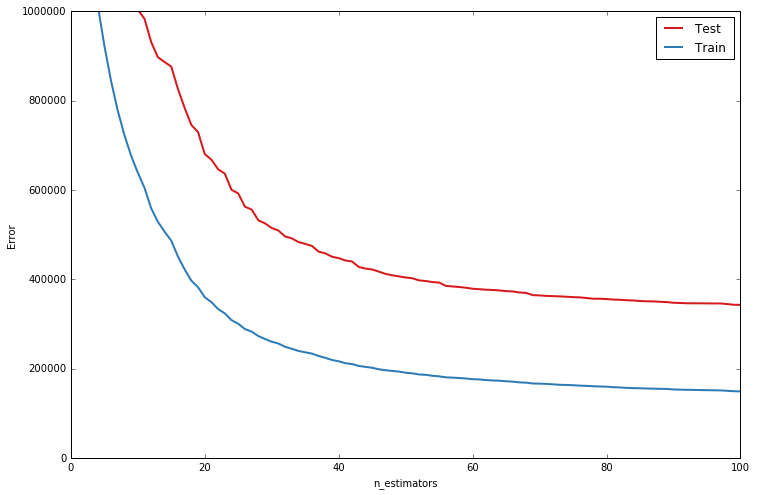

In [72]:
def deviance_plot(est, X_test, y_test, ax = None, label = '', train_color='#2c7bb6', test_color = '#d7191c', alpha= 1.0, ylim = (0,1000000)):

    n_estimators = len(est.estimators_)
    test_dev = np.empty(n_estimators)

    for i, pred in enumerate(est.staged_predict(X_test)):
        test_dev[i] = est.loss_(y_test, pred)

    if ax is None:
        fig = plt.figure(figsize = (12,8))
        ax = plt.gca()

    ax.plot(np.arange(n_estimators) + 1, test_dev, color= test_color, label = 'Test %s' % label, linewidth=2, alpha=alpha)
    ax.plot(np.arange(n_estimators) + 1, est.train_score_, color = train_color, label= 'Train %s' % label, linewidth=2, alpha=alpha)
    ax.set_ylabel('Error')
    ax.set_xlabel('n_estimators')
    ax.set_ylim(ylim)
    return test_dev, ax

test_dev, ax = deviance_plot(gbr, X_test, y_test)
ax.legend(loc='upper right')

# add some annotations
# ax.annotate('Lowest test error', xy=(test_dev.argmin() + 1, test_dev.min() + 0.02),
#             xytext=(150, 3.5), **annotation_kw)

# ann = ax.annotate('', xy=(800, test_dev[799]),  xycoords='data',
#                   xytext=(800, est.train_score_[799]), textcoords='data',
#                   arrowprops={'arrowstyle': '<->'})
# ax.text(810, 3.5, 'train-test gap')

In [73]:
import datetime

In [78]:
import flask